# Shyam Parikh
## I will be analyzing Cluster 0 for this project

In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import joblib

In [118]:
df = pd.read_csv('../data/train_data_transformed.csv')
df.head()

,Cash Flow to Equity,Retained Earnings to Total Assets,Revenue per person,Current Liability to Current Assets,Equity to Liability,Cash/Total Assets,Total expense/Assets,Liability-Assets Flag,Total debt/Total net worth,Operating profit per person,...,Current Ratio,Tax rate (A),Fixed Assets to Assets,Fixed Assets Turnover Frequency,Operating Expense Rate,Cash Turnover Rate,Cash/Current Liability,Net Income Flag,Cluster,Bankrupt?
0,0.217546,-0.043381,0.012956,0.021269,0.021996,0.053904,0.013277,0.0,-7.700719,0.219656,...,0.007958,0.000000,0.260497,0.000163,9.293653,48.603120,0.007177,1,2,0
1,0.216729,-0.034301,0.016897,0.019162,0.021986,0.051009,0.014031,0.0,-7.698724,0.222590,...,0.008968,0.140670,0.185825,0.000286,0.000102,47.794965,0.003365,1,0,0
2,0.219318,-0.035592,0.014429,0.014912,0.022242,0.087701,0.013941,0.0,-7.756428,0.224013,...,0.011474,0.079348,0.190924,0.000249,0.000106,0.000135,0.011598,1,1,0
3,0.217730,-0.041187,0.032948,0.023429,0.012704,0.041171,0.008849,0.0,-4.863509,0.225099,...,0.007043,0.000000,0.053158,0.000782,9.286611,49.096282,0.001368,1,2,0
4,0.213984,-0.041363,0.038464,0.022027,0.020352,0.117889,0.021234,0.0,-7.318907,0.225056,...,0.007624,0.196328,0.059349,0.002155,9.265499,42.076560,0.011420,1,2,0


In [119]:
target_clusters = df['Cluster']
target_bankruptcy = df['Bankrupt?']
df.drop(columns=['Cluster'], inplace=True)
df_scaled = (df[df.columns[:-2]] - df[df.columns[:-2]] .mean()) / df[df.columns[:-2]] .std()
df = df_scaled

### 3.1 We have to use a supervised learning technique to predict the indiviudal clusters.
For this example I will use Naive Bayes.

In [120]:
np.random.seed(1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], target_clusters, test_size=0.2, random_state=42)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Train Accuracy: 0.9995694294940797
Test Accuracy: 0.9982788296041308


With Naive Bayes, we get a 99.97% accuracy on the clusters with just training. We also get a 99.91% accuracy when we use a train test split

In [121]:
np.random.seed(1)
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9997847147470398
Test Accuracy: 1.0


In [122]:
log_model.fit(df[df.columns[:-1]], target_clusters)
y_pred = log_model.predict(df[df.columns[:-1]])
accuracy = accuracy_score(target_clusters, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9998277940416739


We even get a better accuracy when we use Logistic Regression Instead of Naive Bayes on Our Train and Test Set. 

We are able to get a 100% accuracy with Logistic Regression. To understand what the features look like, we can use the coefficients feature on the logistic regression to see the important features.

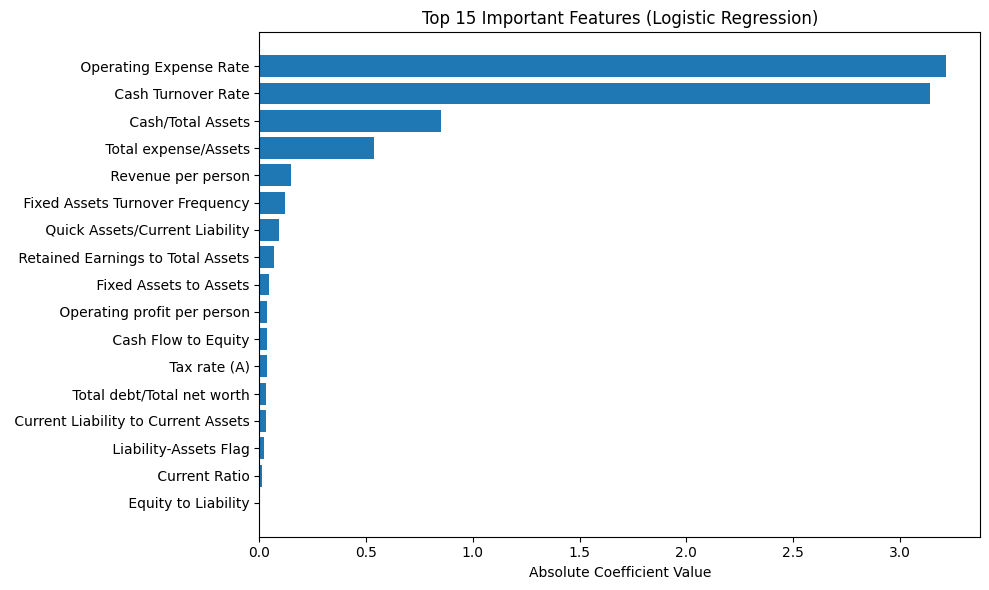

In [123]:
coefficients = log_model.coef_[0]  
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
importance_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][::-1], importance_df['Abs_Coefficient'][::-1])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 15 Important Features (Logistic Regression)")
plt.tight_layout()
plt.show()


From this we see that 4 features have a meaningful impact on each and every individual subgroup. We will extend that and add the next two features as well as they don't seem to be necessarily equal to 0. For those reasons, we will use the following features when we are developing our stacking model: Revenue per person, Total expense/Assets, Cash/Total Assets, Fixed Assets Turnover Frequency, Cash Turnover Rate, and Operating Expense Rate. These seem have the most impact on predicting subgroups with Operating Expense Rate being the most important.

### 3.3.2 Building a Stacking model that predicts whether a company in the subgroup will file for bankruptcy.

In [124]:
df['Cluster'] = target_clusters
df['Bankrupt?'] = target_bankruptcy
shyam_df = df[df['Cluster']==0]
print(f"Total Number of Bankrupt Companies in Cluster 0: {len(shyam_df[shyam_df['Bankrupt?'] == 1])}")
print(f"Total Number of Companies in Cluster 0: {len(shyam_df)}")
target = shyam_df['Bankrupt?']
# we want to take the values that have the most impact on this cluster
shyam_df = shyam_df[importance_df['Feature'].values]
shyam_df = shyam_df[shyam_df.columns[:6]]

Total Number of Bankrupt Companies in Cluster 0: 111
Total Number of Companies in Cluster 0: 2118


In [125]:
np.random.seed(1)
base_models = [
    ('decision_tree', DecisionTreeClassifier(max_depth=20, random_state=1)),
    ('et', ExtraTreesClassifier(class_weight='balanced', n_estimators=100, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=50, random_state=1))
]
print(" ========================================================================")
for x in base_models:
    X_train, X_test, y_train, y_test = train_test_split(shyam_df[shyam_df.columns], target, test_size=0.2, random_state=1)
    model_name, model = x
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    print(f"Train Accuracy for {model_name}: {train_accuracy}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix_train}")
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    print(f"Test Accuracy for {model_name}: {test_accuracy}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix_test}")
print(" ========================================================================")
print("Now, we are just going to use train data and test the accuracy of that model fit")
accuracies = []
true_trues = []
true_falses = []
for x in base_models:
    model_name,model = x
    model.fit(shyam_df, target)
    y_train_pred = model.predict(shyam_df)
    train_accuracy = accuracy_score(target, y_train_pred)
    confusion_matrix_train = confusion_matrix(target, y_train_pred)
    true_falses.append(confusion_matrix_train[1][0])
    true_trues.append(confusion_matrix_train[1][1])
    print(f"Train Accuracy for {model_name}: {train_accuracy}")
    print(f"True Trues: {true_trues[-1]}")
    print(f"True Falses: {true_falses[-1]}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix_train}")
    accuracies.append(train_accuracy)
print(" ========================================================================")  
true_trues = int(np.mean(true_trues))
true_falses = int(np.mean(true_falses)) 
average_accuracy = true_trues / (true_trues + true_falses) 
print(f"Average True Trues: {np.mean(true_trues)}")
print(f"Average True Falses: {np.mean(true_falses)}")
new_average_accuracy = f"{average_accuracy:.2f}[{true_trues}({true_falses})]"
print(f"Average Accuracy: {new_average_accuracy}")

Train Accuracy for decision_tree: 1.0
Confusion Matrix for decision_tree:
[[1597    0]
 [   0   97]]
Test Accuracy for decision_tree: 0.9009433962264151
Confusion Matrix for decision_tree:
[[377  33]
 [  9   5]]
Train Accuracy for et: 1.0
Confusion Matrix for et:
[[1597    0]
 [   0   97]]
Test Accuracy for et: 0.9599056603773585
Confusion Matrix for et:
[[406   4]
 [ 13   1]]
Train Accuracy for random_forest: 0.9988193624557261
Confusion Matrix for random_forest:
[[1597    0]
 [   2   95]]
Test Accuracy for random_forest: 0.9599056603773585
Confusion Matrix for random_forest:
[[406   4]
 [ 13   1]]
Now, we are just going to use train data and test the accuracy of that model fit
Train Accuracy for decision_tree: 1.0
True Trues: 111
True Falses: 0
Confusion Matrix for decision_tree:
[[2007    0]
 [   0  111]]
Train Accuracy for et: 1.0
True Trues: 111
True Falses: 0
Confusion Matrix for et:
[[2007    0]
 [   0  111]]
Train Accuracy for random_forest: 1.0
True Trues: 111
True Falses: 0
C

In [126]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(shyam_df, target, test_size=0.2, random_state=1)

final_estimator = MLPClassifier(hidden_layer_sizes=(100, 100),activation = 'tanh', max_iter=1000, random_state=1)
stacking_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5)
stacking_model.fit(X_train, y_train)
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)


confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
train_accuracy = confusion_matrix_train[1][1] / (confusion_matrix_train[1][0] + confusion_matrix_train[1][1])
test_accuracy = confusion_matrix_test[1][1] / (confusion_matrix_test[1][0] + confusion_matrix_test[1][1])

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Confusion Matrix:\n{confusion_matrix_train}")
print(f"Test Confusion Matrix:\n{confusion_matrix_test}")

Train Accuracy: 0.8144329896907216
Test Accuracy: 0.07142857142857142
Train Confusion Matrix:
[[1597    0]
 [  18   79]]
Test Confusion Matrix:
[[406   4]
 [ 13   1]]


In [127]:
np.random.seed(1)
stacking_model.fit(shyam_df[shyam_df.columns], target)
y_pred = stacking_model.predict(shyam_df[shyam_df.columns])
accuracy_train = accuracy_score(target, y_pred)
confusion_matrix = confusion_matrix(target, y_pred)
print(f"Final Model Accuracy: {accuracy_train}")
print(f"Final Model Confusion Matrix:\n{confusion_matrix}")
true_trues_meta = confusion_matrix[1][1]
true_falses_meta = confusion_matrix[1][0]

Final Model Accuracy: 1.0
Final Model Confusion Matrix:
[[2007    0]
 [   0  111]]


In [128]:
joblib.dump(stacking_model, "../models/model_cluster0.pkl")
joblib.dump(shyam_df.columns, '../models/features_cluster0.pkl')

['../models/features_cluster0.pkl']

### Adding everything back into the group_info.csv

In [129]:
df = pd.read_csv('../data/table_3.csv')
df = df[df[df.columns[0]] != '0']
print(df)
accuracy_traian = true_trues_meta / (true_trues_meta + true_falses_meta)
accuracy_train_format = f"{accuracy_train:.2f}[{true_trues_meta}({true_falses_meta})]"
new_row = pd.DataFrame([{
    df.columns[0]: '0',
    df.columns[1]: 'Shyam Parikh',
    df.columns[2]: new_average_accuracy,
    df.columns[3]: accuracy_train_format,
    df.columns[4]: len(shyam_df.columns),
}])
df = pd.concat([df, new_row], ignore_index=True)
df.to_csv('../data/table_3.csv', index=False)

  Subgroup ID  Name of Student  Average accuracy score base models [TT(TF)]  \
1           2        Lijing Li                                  0.98[55(1)]   
2        Team              NaN                               0.83 [186(12)]   
3           3     Ryan Camburn                                   0.67[3(2)]   
4           1     Ayan Mahmood                                  0.67[17(9)]   

   accuracy score Meta model [TT(TF)]   N_features  
1                      0.8214[46(10)]         5.00  
2                      0.96 [188(10)]         5.75  
3                          1.00[5(0)]         7.00  
4                         1.00[26(0)]         5.00  


### Implementing our models on the test set

In [130]:
df = pd.read_csv('../data/test_data.csv')